## Linker Library Analysis of Illumina Amplicon Sequencing Data

This notebook contains the analysis of aligned reads produced by the script `0_Illumina_preprocess_and_align_reads.py`.

Please make sure to download the input dataset `Illumina` from the Zenodo repository and place it in a folder named `data` at root repository level.

The full downstream analysis is also automated in the script `2_Illumina_analyze_linkers.py`.

For more details, see the `README.md` file in this repository.


---

#### This notebook includes the following steps:
- Comparisons across different barcodes
- Sequencing runs
---

### Notebook setup

In [1]:
# --- Import necessary modules ---
import os
import sys
import os.path
from pathlib import Path

notebook_dir = Path().resolve()
repo_root = notebook_dir.parent.parent 
sys.path.append(str(repo_root))

import glob
import gzip
import json
import re
import shutil
import pickle as pkl
from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqIO import QualityIO 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import seaborn as sns
from scripts.utils import dna_rev_comp, translate_dna2aa
from scripts.plotting import *
from scripts.Illumina_functions import *
from scripts.linker_analysis_functions import *


# ======================== PLOTTING SETTINGS ========================


# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================
# --- Pre-defined figure dimensions for multi-panel plots ---
lw = 1
fs = 7
hi = 10.5 *0.75
wi3 = 2.24 
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

### Processing and standard analysis 

In [3]:
# --- Define analysis parameters ---

Bc = "BC1" # Barcode identifier
read_dir = "R1" # Read direction (R1 or R2)
variant = "R36" # Experimental variant
experiment = 'AraC-R2-LOV_POGO_RAMPhaGE_NGS'
homedir = repo_root / 'data' / 'Illumina' / experiment

base_dir = repo_root

# --- Load BLAST alignment output (JSON format) ---
with open(f"{homedir}/blast/alignments/BC1/{variant}_{Bc}_S1_Nt_filt_{read_dir}.out", "r") as file:
    blast_output = json.load(file)

# Confirm that the loaded BLAST output is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>

# --- Extract BLAST alignments (list of hit entries) ---
blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()

# --- Define wild-type linker sequences (for comparison/reference) ---
wt_left_linker = "INESSGL"
wt_right_linker = "IDEAAKGSLHPP"


# --- Define region of interest (ROI) within the amplicon ---
# These are DNA sequences marking the start and end of the LOV2 insert
LOV_startseq = "gccacaa".upper()
# LOV_startseq = "gggagcctgcatcc".upper() ### GSLHP (left side after linker)
LOV_endseq = "tgctgaaaac".upper() 

# --- Define the known protein and DNA sequence of LOV2 insert ---
LOV2_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
LOV2_gene = "ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa".upper()

<class 'dict'>


In [4]:
# --- Load configuration parameters ---
with open(f"{homedir}/config.json") as f:
    config = json.load(f)

# --- Prepare output directory for notebook-generated figures ---

FigFolder = f"{base_dir}/final_output/{variant}/notebook/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

# --- Retrieve the full reference amplicon sequence from config ---
amplicon_seq = config["amplicon"]

# --- Get exact position of the LOV2 region within the full amplicon sequence ---
LOV2_startidx = amplicon_seq.index(LOV_startseq)
LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)


In [5]:
# --- Filter blast alignments for regions that include LOV2 start site (+- 10 nucleotides) ---
print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")


# --- Determine which region of the insert to filter for ---
# If analyzing R1 reads, we filter for the start of the LOV2 insert;
# if R2, we filter for the end of the LOV2 insert.
filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

# --- Apply filtering: keep only alignments that span the LOV2 insertion site ---
# Specifically, we keep reads whose aligned segment starts before (ROI - 10) and ends after (ROI + 10)
blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]


print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")


31553 alignments before filtering for LOV2 insertion site
22475 alignments after filtering for LOV2 insertion site


In [ ]:
# ============================== DIVIDE READS INTO LINKER AND INSERT ==============================

# --- Define the sequence at which to split the reads ---
# For R1: we use the start of LOV2 (LOV_startseq) as the split point.
# For R2: we use the end of LOV2 (LOV_endseq) as the split point.
cut_site_seq = LOV_startseq if read_dir=="R1" else LOV_endseq

print(LOV_startseq)

# --- Split BLAST alignments into linker and insert (LOV2) parts ---
# This function returns:
# - linker_alignments: all reads aligned to the linker region
# - LOV2_alignments: all reads aligned to the LOV2 insert region
# - coverage: per-position coverage across the whole sequence
linker_alignments, LOV2_alignments, coverage = divide_alignments(blast_alignments,cut_site_seq, query_seq=LOV2_gene ,read_dir=read_dir)

# ============================== ANALYZE LINKER SEQUENCES ==============================

# --- Extract all linker variants and their frequencies ---
# This function compares each linker sequence to the wild-type linker.
# It returns:
# - linkers: dictionary of variant sequences and their read counts
# - linker_list: list of all linker variants (including wt and mutants)
linkers, linker_list = get_linker_variants(linker_alignments,wt_linker = wt_left_linker if read_dir=="R1" else wt_right_linker, read_dir=read_dir)

GCCACAA
2 sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)


In [ ]:
# ============================== PROCESS LINKER FREQUENCIES ==============================

## --- Sort linker variants by their frequency in descending order ---
linkers_sorted = {k: v for k, v in sorted(linkers.items(), key=lambda item: item[1], reverse=True)}

## --- Calculate the total number of reads that were assigned to linker variants ---
total_reads = sum(linkers_sorted.values())

## --- Convert absolute counts into percentages ---
linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

# ============================== FILTER LINKER VARIANTS ==============================

## --- Exclude wild-type (wt) linker from the analysis ---
linkers_sorted_perc.pop("wt")

## --- Filter out low-frequency variants (< 0.05%) ---
linkers_perc_filt = {k: v for k, v in linkers_sorted_perc.items() if v > 0.05}


# ============================== RENAME VARIANTS FOR VISUALIZATION ==============================

## --- Rename linker variants for readability in plots ---
linkers_perc_filt, linker_renaming = rename_left_linkers(linkers_perc_filt.keys(), linkers_perc_filt) if read_dir=="R1" else rename_right_linkers(linkers_perc_filt.keys(), linkers_perc_filt)


INESSGL -> SG
INESVL -> V
INESPL -> P
INESLL -> L
INESSL -> S
INESKL -> K
INESWL -> W
INESAL -> A
INESRL -> R
INESQL -> Q
INESTL -> T
INESNL -> N
INESCL -> C
INESGL -> G
INESFL -> F
INESHL -> H
INESDL -> D
INESML -> M
INESGTGL -> GTG
INESGSGL -> GSG
INESGWGL -> GWG
INESGVGL -> GVG
INESGAGL -> GAG
INESGMGL -> GMG
INESIL -> I
INESPPL -> PP
INESEL -> E
INESGQGL -> GQG
INESGGL -> GG
INESGCGL -> GCG
INESGKGL -> GKG
INESGGGL -> GGG
INESGEGL -> GEG
INESYL -> Y
INESGRGL -> GRG
INESGHGL -> GHG
INESGDGL -> GDG
INESGPGL -> GPG
INESGFGL -> GFG
INESGIGL -> GIG
INESGNGL -> GNG
INESGYGL -> GYG
INESGLGL -> GLG
INESGPPPGL -> GPPPG
INESGSGGL -> GSGG
INESGSGSGL -> GSGSG
INESGGSGL -> GGSG
INESGPPGL -> GPPG
INEL -> (-1del)
INESSDL -> SD


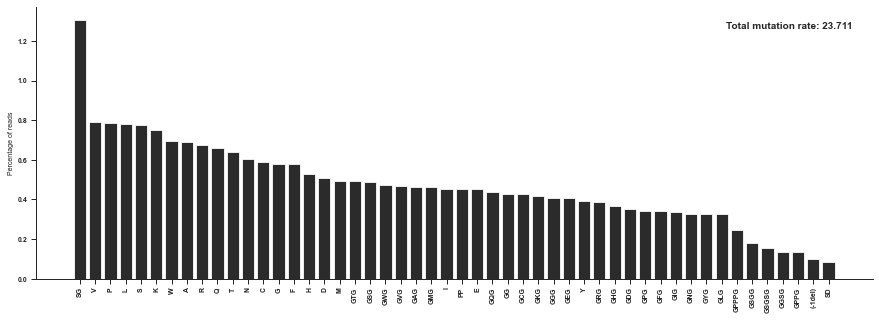

In [ ]:
# ============================== PLOT LINKER VARIANT DISTRIBUTION ==============================
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
# plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()